# 1. Load Library

In [ ]:
from confluent_kafka import Consumer, KafkaException
import json
import pandas as pd
import time

# 2. Kafka Configuration

In [ ]:
KAFKA_CONFIG = {
    'bootstrap.servers': '',
    'security.protocol': 'SASL_SSL',
    'sasl.mechanisms': 'PLAIN',
    'sasl.username': '',
    'sasl.password': '',
    'group.id': 'reddit-nlp-consumer-group-1',
    'auto.offset.reset': 'earliest'
}

TOPIC = 'reddit-tariff-topic'

# 3. Consume Messages

In [ ]:
consumer = Consumer(KAFKA_CONFIG)
consumer.subscribe(['reddit-tariff-topic'])

raw_posts = []
timeout_count = 0

print("📡 Listening for messages from Kafka...")

while True:
    msg = consumer.poll(timeout=2.0)
    if msg is None:
        print("⌛ No message received.")
        timeout_count += 1
        if timeout_count > 5:
            print("🛑 Exiting — no more messages.")
            break
        continue
    if msg.error():
        raise KafkaException(msg.error())

    data = json.loads(msg.value().decode("utf-8"))
    raw_posts.append(data)
    print(f"✅ Received post: {data.get('title')[:60]}... (Total: {len(raw_posts)})")

consumer.close()
print(f"🎉 Fetched total {len(raw_posts)} posts.")

📡 Listening for messages from Kafka...
✅ Received post: Homeschooled by a pigeon... (Total: 1)
✅ Received post: The internet will always remain undefeated... (Total: 2)
✅ Received post: Oh my god... (Total: 3)
✅ Received post: The Senate has just voted to CANCEL Trump's tariffs on Canad... (Total: 4)
✅ Received post: Barstool Sports founder and Trump endorser Dave Portnoy reve... (Total: 5)
✅ Received post: Trump's tariffs send stock market falling... (Total: 6)
✅ Received post: Jack Daniel’s maker says Canada pulling U.S. alcohol off sto... (Total: 7)
✅ Received post: Canadian stores still encouraging US boycott despite tariff ... (Total: 8)
✅ Received post: China Imposes 34% Tariffs on All US Imports... (Total: 9)
✅ Received post: History Repeats Itself... (Total: 10)
✅ Received post: Trump Slams Amazon's Tariff Labeling as ‘Hostile, Political’... (Total: 11)
✅ Received post: Adam Schiff Calls For Insider Trading Investigation into Tru... (Total: 12)
✅ Received post: Yep, you voted t

# 4. Convert to DataFrames

In [ ]:
print(f"Total posts: {len(raw_posts)}")

Total posts: 245


## Posts DataFrame

In [ ]:
df_posts = pd.DataFrame([{
    "post_id": p.get("post_id"),
    "subreddit": p.get("subreddit"),
    "keyword": p.get("keyword"),
    "title": p.get("title"),
    "selftext": p.get("selftext"),
    "score": p.get("score"),
    "url": p.get("url"),
    "created_utc": p.get("created_utc"),
    "num_comments": len(p.get("comments", []))
} for p in raw_posts])

## Comments DataFrame

In [ ]:
comments_flat = []
for p in raw_posts:
    for c in p.get("comments", []):
        comments_flat.append({
            "post_id": p.get("post_id"),
            "comment_id": c.get("comment_id"),
            "parent_id": c.get("parent_id"),
            "author": c.get("author"),
            "body": c.get("body"),
            "score": c.get("score"),
            "created_utc": c.get("created_utc"),
            "depth": c.get("depth")
        })

df_comments = pd.DataFrame(comments_flat)

# 5. Overview

In [ ]:
print("Posts DataFrame preview:")
display(df_posts.head())

print("Comments DataFrame preview:")
display(df_comments.head())

Posts DataFrame preview:


,post_id,subreddit,keyword,title,selftext,score,url,created_utc,num_comments
0,1js8evq,all,tariff,Homeschooled by a pigeon,,81953,https://i.redd.it/s6ql6ovsu1te1.jpeg,1.743873e+09,50
1,1jvbqtk,all,tariff,The internet will always remain undefeated,,57278,https://i.redd.it/i2g8iu88iute1.jpeg,1.744220e+09,50
2,1ifbpjr,all,tariff,Oh my god,,55393,https://i.redd.it/snsr9zz5ekge1.png,1.738432e+09,50
3,1jq6nqu,all,tariff,The Senate has just voted to CANCEL Trump's ta...,,54191,https://v.redd.it/sr83hncu3jse1,1.743646e+09,50
4,1jrjbrq,all,tariff,Barstool Sports founder and Trump endorser Dav...,,50549,https://v.redd.it/xmnle8ve5vse1,1.743792e+09,50


Comments DataFrame preview:


,post_id,comment_id,parent_id,author,body,score,created_utc,depth
0,1js8evq,mlkicmu,t3_1js8evq,Huxtopher,"To be honest, this is exactly the level of stu...",4783,1.743874e+09,0
1,1js8evq,mlks7df,t3_1js8evq,13CrazyCat13,Please stop insulting the pigeons!,1628,1.743877e+09,0
2,1js8evq,mlkwcjs,t3_1js8evq,devinstated1,Dude is either a very good rage baiter/satire ...,962,1.743879e+09,0
3,1js8evq,mllpyu4,t1_mlkicmu,Klutzy-Ad-6705,People like this have to study for three days ...,911,1.743889e+09,1
4,1js8evq,mll8zpm,t1_mlks7df,Pigeon_Bucket,"Yeah, really. Pigeons are beautiful, intellige...",378,1.743883e+09,1


In [ ]:
df_posts.to_csv("/content/drive/MyDrive/BUDT737_Project/df_posts.csv", index=False, encoding="utf-8-sig")
df_comments.to_csv("/content/drive/MyDrive/BUDT737_Project/df_comments.csv", index=False, encoding="utf-8-sig")

# 6. Data Cleaning

## Convert TimeStamp

In [ ]:
df_posts["created_date"] = pd.to_datetime(df_posts["created_utc"], unit="s", errors="coerce")
df_comments["created_date"] = pd.to_datetime(df_comments["created_utc"], unit="s", errors="coerce")

In [ ]:
df_posts.head()

,post_id,subreddit,keyword,title,selftext,score,url,created_utc,num_comments,created_date
0,1js8evq,all,tariff,Homeschooled by a pigeon,,81953,https://i.redd.it/s6ql6ovsu1te1.jpeg,1.743873e+09,50,2025-04-05 17:15:52
1,1jvbqtk,all,tariff,The internet will always remain undefeated,,57278,https://i.redd.it/i2g8iu88iute1.jpeg,1.744220e+09,50,2025-04-09 17:38:15
2,1ifbpjr,all,tariff,Oh my god,,55393,https://i.redd.it/snsr9zz5ekge1.png,1.738432e+09,50,2025-02-01 17:42:43
3,1jq6nqu,all,tariff,The Senate has just voted to CANCEL Trump's ta...,,54191,https://v.redd.it/sr83hncu3jse1,1.743646e+09,50,2025-04-03 02:12:40
4,1jrjbrq,all,tariff,Barstool Sports founder and Trump endorser Dav...,,50549,https://v.redd.it/xmnle8ve5vse1,1.743792e+09,50,2025-04-04 18:43:09


In [ ]:
# Convert 'created_date' to datetime objects if it's not already
# df_posts['created_date'] = pd.to_datetime(df_posts['created_date'])

# Extract year and month
df_posts['year'] = df_posts['created_date'].dt.year
df_posts['month'] = df_posts['created_date'].dt.month

# Group by year and month and count the number of posts
post_counts = df_posts.groupby(['year', 'month']).size().reset_index(name='post_count')

# Display the result
post_counts


,year,month,post_count
0,2024,9,2
1,2024,10,1
2,2024,11,26
3,2024,12,6
4,2025,1,16
5,2025,2,33
6,2025,3,41
7,2025,4,111
8,2025,5,9


In [ ]:
df_comments.head()

,post_id,comment_id,parent_id,author,body,score,created_utc,depth,created_date
0,1js8evq,mlkicmu,t3_1js8evq,Huxtopher,"To be honest, this is exactly the level of stu...",4783,1.743874e+09,0,2025-04-05 17:27:27
1,1js8evq,mlks7df,t3_1js8evq,13CrazyCat13,Please stop insulting the pigeons!,1628,1.743877e+09,0,2025-04-05 18:21:04
2,1js8evq,mlkwcjs,t3_1js8evq,devinstated1,Dude is either a very good rage baiter/satire ...,962,1.743879e+09,0,2025-04-05 18:44:10
3,1js8evq,mllpyu4,t1_mlkicmu,Klutzy-Ad-6705,People like this have to study for three days ...,911,1.743889e+09,1,2025-04-05 21:32:59
4,1js8evq,mll8zpm,t1_mlks7df,Pigeon_Bucket,"Yeah, really. Pigeons are beautiful, intellige...",378,1.743883e+09,1,2025-04-05 19:56:32


## Clean Comment Content

In [ ]:
df_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12250 entries, 0 to 12249
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   post_id       12250 non-null  object        
 1   comment_id    12250 non-null  object        
 2   parent_id     12250 non-null  object        
 3   author        12250 non-null  object        
 4   body          12250 non-null  object        
 5   score         12250 non-null  int64         
 6   created_utc   12250 non-null  float64       
 7   depth         12250 non-null  int64         
 8   created_date  12250 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 861.5+ KB


In [ ]:
df_comments = df_comments[
    df_comments["body"].notnull() &
    ~df_comments["body"].isin(["[deleted]", "[removed]"])
].copy()

# 7. Sentiment Distributing

In [ ]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# ========== Step 1: Create a copy ========== #
df_comments_sentiment = df_comments.copy()

# ========== Step 2: Clean invalid comments (only remove [deleted], [removed]) ========== #
df_comments_sentiment = df_comments_sentiment[
    df_comments_sentiment["body"].notnull() &
    ~df_comments_sentiment["body"].isin(["[deleted]", "[removed]"])
].copy()

# ========== Step 3: Download and initialize VADER sentiment analyzer ========== #
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

# ========== Step 4: Add sentiment score ========== #
df_comments_sentiment["sentiment_score"] = df_comments_sentiment["body"].apply(
    lambda text: sia.polarity_scores(text)["compound"]
)

# ========== Step 5: Add sentiment classification label ========== #
def classify_sentiment(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

df_comments_sentiment["sentiment_label"] = df_comments_sentiment["sentiment_score"].apply(classify_sentiment)

# ========== Step 6: Preview and verify ========== #
print("🎯 Sentiment label distribution:")
print(df_comments_sentiment["sentiment_label"].value_counts())

display(df_comments_sentiment[["body", "sentiment_score", "sentiment_label"]].head())


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


🎯 情绪标签分布：
sentiment_label
negative    5359
positive    4694
neutral     2197
Name: count, dtype: int64


,body,sentiment_score,sentiment_label
0,"To be honest, this is exactly the level of stu...",0.1027,positive
1,Please stop insulting the pigeons!,-0.5255,negative
2,Dude is either a very good rage baiter/satire ...,-0.8436,negative
3,People like this have to study for three days ...,0.3612,positive
4,"Yeah, really. Pigeons are beautiful, intellige...",0.8542,positive


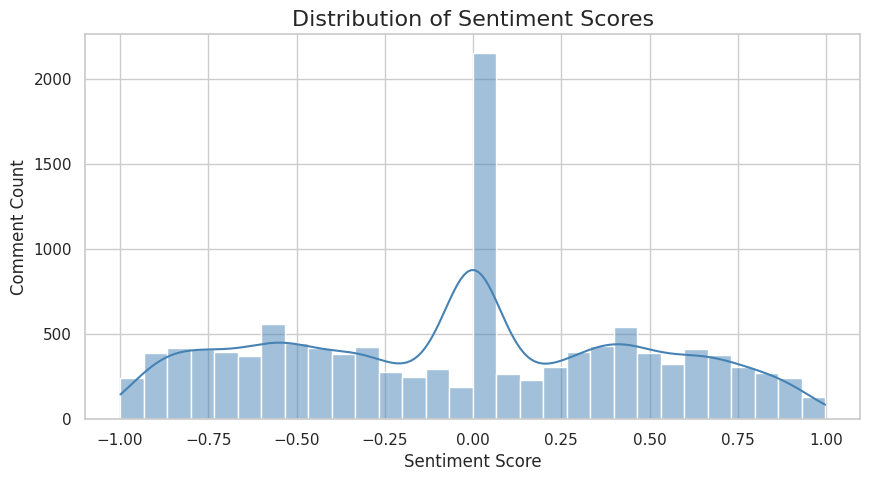

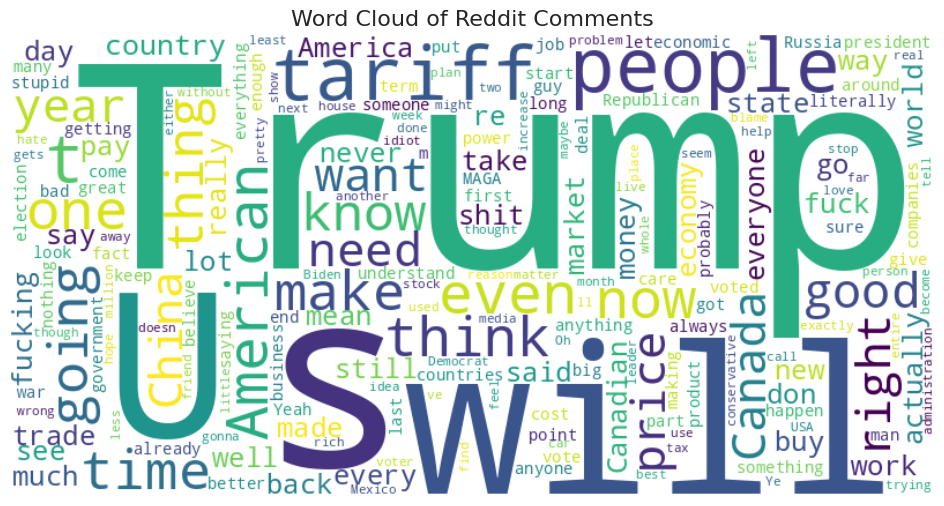

🧠 High Sentiment Comments (score > 0.8):


,post_id,author,body,sentiment_score
0,1jx8y54,emjaycue,Reposting this ELI5 I posted elsewhere earlier...,0.9968
1,1jtv9kv,Zeal_Iskander,The MOST important concept I’ve learned from e...,0.9935
2,1jvup93,incongruity,This is truly a wicked problem because each bi...,0.9913
3,1ju9a4o,badluckbrians,"To be fair, Trump *is* good at talking out bot...",0.9891
4,1jrdeob,jdoeinboston,"Yeah, everyone is ready to celebrate this, but...",0.9878
5,1hpmys5,Jarska15,Just 2 days ago I saw an American friend of mi...,0.9874
6,1jtlcb2,M8oMyN8o,The European Union and the rest of the core An...,0.9868
7,1kebnaw,Useful-Scratch-72,Yes and there have been job losses in the auto...,0.9844
8,1j9jsf7,NorthStarZero,"The answer is simple. Not *easy*, mind you, bu...",0.9844
9,1jo6v9m,deviltrombone,"We have the nuclear, it's very powerful. As th...",0.9842


In [ ]:
# Install and import required packages for word cloud and visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set(style="whitegrid")

# ==========  1.Distribution of Sentiment Scores ==========
plt.figure(figsize=(10, 5))
sns.histplot(df_comments_sentiment["sentiment_score"], bins=30, kde=True, color='steelblue')
plt.title("Distribution of Sentiment Scores", fontsize=16)
plt.xlabel("Sentiment Score", fontsize=12)
plt.ylabel("Comment Count", fontsize=12)
plt.grid(True)
plt.show()

# ========== 2.Word Cloud of Comments ==========
# Merge all comment texts
all_text = " ".join(df_comments_sentiment["body"].astype(str))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", collocations=False).generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Reddit Comments", fontsize=16)
plt.show()

# ========== 3.Average Sentiment per Post ==========
avg_sentiment_by_post = df_comments_sentiment.groupby("post_id")["sentiment_score"].mean().reset_index()
avg_sentiment_by_post.columns = ["post_id", "avg_sentiment"]

# Display average sentiment values of the top posts
avg_sentiment_by_post.sort_values("avg_sentiment", ascending=False).head()

# ========== 4.Extract High Sentiment Comments (score > 0.8) ==========
high_sentiment_comments = df_comments_sentiment[df_comments_sentiment["sentiment_score"] > 0.8][
    ["post_id", "author", "body", "sentiment_score"]
].sort_values("sentiment_score", ascending=False).reset_index(drop=True)

print("🧠 High Sentiment Comments (score > 0.8):")
display(high_sentiment_comments.head(10))  # Or any number

# 8. Merged with title and body with RoBERTa

In [ ]:
# Step 1: Prepare post data (extract only post_id, title, created_date)
df_posts["created_date"] = pd.to_datetime(df_posts["created_utc"], unit="s", errors="coerce")
df_post_text = df_posts[["post_id", "created_date", "title"]].copy()
df_post_text.rename(columns={"title": "text"}, inplace=True)

# Step 2: Prepare comment data (extract only post_id, body, created_date)
df_comments_sentiment["created_date"] = pd.to_datetime(df_comments_sentiment["created_utc"], unit="s", errors="coerce")
df_comment_text = df_comments_sentiment[["post_id", "created_date", "body"]].copy()
df_comment_text.rename(columns={"body": "text"}, inplace=True)

# Step 3: Merge both datasets (stack them together, do not merge text fields)
df_text_stream = pd.concat([df_post_text, df_comment_text], ignore_index=True)

# Step 4: Sort the stream (optional, in chronological order)
df_text_stream = df_text_stream.sort_values(by="created_date").reset_index(drop=True)

# Step 5: Preview
print("📊 Time-ordered Text Stream (title + comments):")
display(df_text_stream.head(10))

📊 Time-ordered Text Stream (title + comments):


,post_id,created_date,text
0,1ff3qfr,2024-09-12 14:20:07,[OC] Visualization of which presidential candi...
1,1ff3qfr,2024-09-12 14:23:40,"That was my biggest gripe with ABC, halfway th..."
2,1ff3qfr,2024-09-12 14:25:22,BuT iT wAs ThReE oN one!!!!!! /s
3,1ff3qfr,2024-09-12 14:26:54,They even aggressively stopped her the one tim...
4,1ff3qfr,2024-09-12 14:30:03,I hate that making basic statements like “peop...
5,1ff3qfr,2024-09-12 14:30:52,Harris probably could've gotten the last word ...
6,1ff3qfr,2024-09-12 14:30:53,My interpretation of this graph: guy had plent...
7,1ff3qfr,2024-09-12 14:31:06,"Yeah, that one really irked me."
8,1ff3qfr,2024-09-12 14:32:57,Watched the whole thing. I got the feeling the...
9,1ff3qfr,2024-09-12 14:33:11,Trump: “they rigged the debate by letting me t...


## Load model and tokenizer for emotion classification RoBERTa emotion classification model

In [ ]:
!pip install transformers --quiet

In [ ]:
from transformers import pipeline
emotion_classifier = pipeline(
    task="text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    top_k=None,
    truncation=True,
    return_all_scores=True
)

Device set to use cpu


## Define function to extract dominant emotion

In [ ]:
text = "I'm so disappointed in this policy. It's a total disaster."
emotion_classifier(text)

[[{'label': 'sadness', 'score': 0.6299149394035339},
  {'label': 'disgust', 'score': 0.20407120883464813},
  {'label': 'neutral', 'score': 0.06329584866762161},
  {'label': 'surprise', 'score': 0.04756849259138107},
  {'label': 'anger', 'score': 0.041862230747938156},
  {'label': 'fear', 'score': 0.011286485008895397},
  {'label': 'joy', 'score': 0.0020008108112961054}]]

In [ ]:
def get_dominant_emotion(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return "empty"

    try:
        results = emotion_classifier(text)
        if isinstance(results, list) and len(results) > 0:
            top_emotion = max(results[0], key=lambda x: x["score"])
            return top_emotion["label"]
        else:
            return "unknown"
    except Exception as e:
        print(f"⚠️ Error processing: {text[:30]}... — {e}")
        return "error"

In [ ]:
emotion_results = []

for idx, row in df_text_stream.iterrows():
    text = row["text"]
    created_date = row["created_date"]

    # emotion classify
    label = get_dominant_emotion(text)
    emotion_results.append(label)

    # monitoring
    print(f"[{idx+1}/{len(df_text_stream)}] 🗓 {created_date} | 🧾 Text: {text[:50]}... | 🎭 Emotion: {label}")

print("\n✅ All done")

# Return to DataFrame
df_text_stream["emotion_label"] = emotion_results

流式输出内容被截断，只能显示最后 5000 行内容。
[8115/12495] 🗓 2025-04-05 11:37:59 | 🧾 Text: *"Animals and insects live there. We'll tariff the... | 🎭 Emotion: neutral
[8116/12495] 🗓 2025-04-05 11:43:02 | 🧾 Text: My guess, he asked Musk, who used Ai. Because of c... | 🎭 Emotion: neutral
[8117/12495] 🗓 2025-04-05 11:44:53 | 🧾 Text: This is peak comedy. They are taking a piss and re... | 🎭 Emotion: disgust
[8118/12495] 🗓 2025-04-05 11:46:02 | 🧾 Text: Anyone who voted for this mess should lose their r... | 🎭 Emotion: anger
[8119/12495] 🗓 2025-04-05 11:49:01 | 🧾 Text: “Cradle the balls, stroke the shaft, and slurp up ... | 🎭 Emotion: neutral
[8120/12495] 🗓 2025-04-05 11:53:49 | 🧾 Text: It’s intentional. Trump is an idiot, but he’s a us... | 🎭 Emotion: neutral
[8121/12495] 🗓 2025-04-05 11:54:36 | 🧾 Text: I felt better thinking an AI is running things unt... | 🎭 Emotion: disgust
[8122/12495] 🗓 2025-04-05 11:54:57 | 🧾 Text: 'Dumbest' Recession Ever: Democrats Prepare To Mak... | 🎭 Emotion: fear
[8123/12495] 🗓 202

In [ ]:
df_text_stream["emotion_label"]

,emotion_label
0,neutral
1,anger
2,neutral
3,neutral
4,disgust
...,...
12490,neutral
12491,neutral
12492,anger
12493,neutral


In [ ]:
df_text_stream["emotion_label"].value_counts()

,count
emotion_label,
neutral,6084
anger,2133
disgust,1811
surprise,1036
sadness,516
fear,472
joy,443


In [ ]:
# Save df_text_stream as CSV to Colab local environment (under /content)
csv_path = "/content/drive/MyDrive/BUDT737_Project/df_text_stream.csv"
df_text_stream.to_csv(csv_path, index=False)

csv_path

'/content/drive/MyDrive/BUDT737_Project/df_text_stream.csv'

# Store on GCP & GCS

In [ ]:
!pip install --upgrade google-cloud-storage

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.cloud import storage

def upload_to_gcs(local_file_path, bucket_name, destination_blob_name):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(local_file_path)
    print(f"✅ Uploaded {local_file_path} to gs://{bucket_name}/{destination_blob_name}")

In [ ]:
upload_to_gcs(
    local_file_path="/content/drive/MyDrive/BUDT737_Project/df_text_stream.csv",
    bucket_name="tariff-data-ziqi",  # bucket
    destination_blob_name="reddit_data/df_text_stream.csv"
)

✅ Uploaded /content/drive/MyDrive/BUDT737_Project/df_text_stream.csv to gs://tariff-data-ziqi/reddit_data/df_text_stream.csv


# Write back to Kafka

In [ ]:
# STEP 0: Install client
!pip install -q confluent-kafka

# STEP 1: Import libraries
import pandas as pd
import json
from confluent_kafka import Producer

# STEP 2: Read your CSV file
csv_path = "/content/drive/MyDrive/BUDT737_Project/df_text_stream.csv"
df = pd.read_csv(csv_path)

# STEP 3: Define Kafka configuration
kafka_config = {
    "bootstrap.servers": "pkc-921jm.us-east-2.aws.confluent.cloud:9092",
    "security.protocol": "SASL_SSL",
    "sasl.mechanisms": "PLAIN",
    "sasl.username": "WSAS5RJB4L626KGZ",
    "sasl.password": "pV8yOfEtwP2vyMPgS9FOS+aWhiKZp7Yz63fK152bAqizC8cdVuU59mtKIco1cYZF",
    "client.id": "colab-csv-producer"
}

# STEP 4: Initialize Kafka Producer
producer = Producer(kafka_config)

# STEP 5: Define delivery callback
def delivery_report(err, msg):
    if err is not None:
        print(f"❌ Delivery failed: {err}")
    else:
        print(f"✅ Message delivered to {msg.topic()} [{msg.partition()}]")

# STEP 6: Send each row in CSV as JSON to Kafka
topic_name = "reddit-tariff-topic"

for _, row in df.iterrows():
    message_dict = row.to_dict()
    message_json = json.dumps(message_dict)
    producer.produce(
        topic=topic_name,
        key=str(row.get("post_id", "default")),
        value=message_json,
        callback=delivery_report
    )
    producer.poll(0)

# STEP 7: Flush all pending messages
producer.flush()


流式输出内容被截断，只能显示最后 5000 行内容。
✅ Message delivered to reddit-tariff-topic [1]
✅ Message delivered to reddit-tariff-topic [0]
✅ Message delivered to reddit-tariff-topic [0]
✅ Message delivered to reddit-tariff-topic [0]
✅ Message delivered to reddit-tariff-topic [0]
✅ Message delivered to reddit-tariff-topic [0]
✅ Message delivered to reddit-tariff-topic [0]
✅ Message delivered to reddit-tariff-topic [0]
✅ Message delivered to reddit-tariff-topic [0]
✅ Message delivered to reddit-tariff-topic [0]
✅ Message delivered to reddit-tariff-topic [0]
✅ Message delivered to reddit-tariff-topic [0]
✅ Message delivered to reddit-tariff-topic [0]
✅ Message delivered to reddit-tariff-topic [0]
✅ Message delivered to reddit-tariff-topic [0]
✅ Message delivered to reddit-tariff-topic [3]
✅ Message delivered to reddit-tariff-topic [3]
✅ Message delivered to reddit-tariff-topic [3]
✅ Message delivered to reddit-tariff-topic [3]
✅ Message delivered to reddit-tariff-topic [3]
✅ Message delivered to reddit-tar

0